# 2-1. 프로젝트 : 폐렴 진단기 성능개선

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

### Step 1. 실험환경 Set-up

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 2

print(ROOT_PATH)

/aiffel/aiffel


### Step 2. 데이터 준비하기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [10]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [11]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

# Augmentation 

In [29]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    # 다른 증강 기법을 추가할 수 있습니다.
    return image, label

In [30]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.map(
        augment,
        num_parallel_calls= 2 
    )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [31]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [32]:
for image, label in train_ds.take(3):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True


In [33]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)


624


In [34]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.bool)>

### Step 3. 데이터 시각화

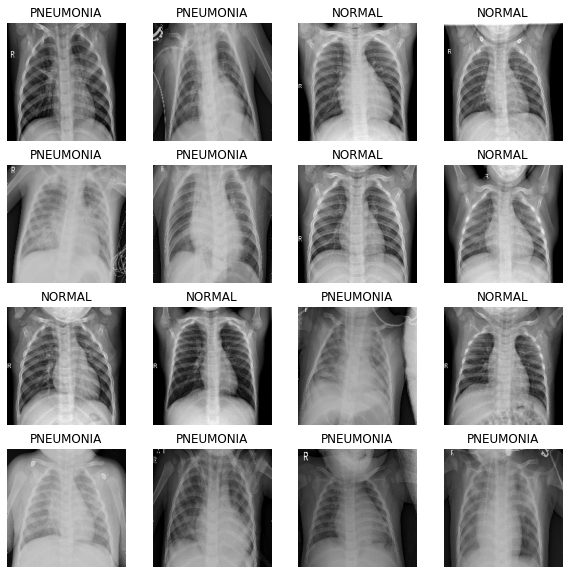

In [35]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# CNN

In [36]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [37]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [38]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### Step 5. 데이터 imbalance 처리

In [39]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


### Step 6. 모델 훈련

In [40]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [41]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 63s 196ms/step - loss: 0.3741 - accuracy: 0.8125 - precision: 0.9564 - recall: 0.7836 - val_loss: 0.7454 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 52s 199ms/step - loss: 0.2293 - accuracy: 0.9131 - precision: 0.9702 - recall: 0.9112 - val_loss: 1.2202 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 52s 200ms/step - loss: 0.1844 - accuracy: 0.9318 - precision: 0.9803 - recall: 0.9270 - val_loss: 0.1394 - val_accuracy: 0.9567 - val_precision: 0.9891 - val_recall: 0.9516
Epoch 4/10
261/261 [==============================] - 53s 202ms/step - loss: 0.1719 - accuracy: 0.9394 - precision: 0.9827 - recall: 0.9350 - val_loss: 0.1243 - val_accuracy: 0.9490 - val_precision: 0.9385 - val_recall: 0.9961
Epoch 5/10
261/261 [==============================] - 53s 205ms/step - loss: 0.1577 - accura

### Step 7. 결과 확인과 시각화

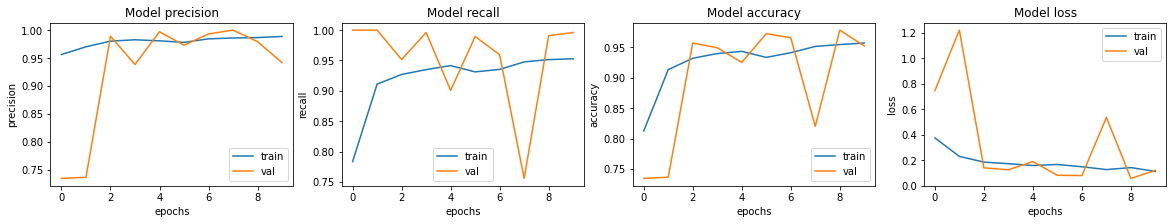

In [42]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [43]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 114ms/step - loss: 1.0690 - accuracy: 0.6923 - precision: 0.6701 - recall: 1.0000
Loss: 1.0690159797668457,
Accuracy: 0.692307710647583,
Precision: 0.6701030731201172,
Recall: 1.0


### Step 4. ResNet-18 구현

In [44]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense

def build_residual_block(x, filters, stride=1):
    # 첫 번째 컨볼루션 레이어
    x_shortcut = x
    x = Conv2D(filters, kernel_size=3, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # 두 번째 컨볼루션 레이어
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Residual 연결
    if stride != 1 or x.shape[-1] != x_shortcut.shape[-1]:
        x_shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='valid')(x_shortcut)
        x_shortcut = BatchNormalization()(x_shortcut)

    x = Add()([x, x_shortcut])
    x = ReLU()(x)

    return x

def build_resnet18_model(input_shape=(180, 180, 3), num_classes=1):
    input_layer = Input(shape=input_shape)

    # 첫 번째 레이어
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    # Residual Block 반복
    x = build_residual_block(x, filters=64)
    x = build_residual_block(x, filters=64)
    x = build_residual_block(x, filters=128, stride=2)
    x = build_residual_block(x, filters=128)
    x = build_residual_block(x, filters=256, stride=2)
    x = build_residual_block(x, filters=256)
    x = build_residual_block(x, filters=512, stride=2)
    x = build_residual_block(x, filters=512)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)

    # Fully Connected Layer
    x = Dense(units=num_classes, activation='sigmoid')(x)

    # 모델 정의
    model = tf.keras.Model(inputs=input_layer, outputs=x)

    return model

#모델 생성
resnet18_model = build_resnet18_model()

#모델 요약
resnet18_model.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 90, 90, 64)   9472        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_74 (BatchNo (None, 90, 90, 64)   256         conv2d_64[0][0]                  
__________________________________________________________________________________________________
re_lu_51 (ReLU)                 (None, 90, 90, 64)   0           batch_normalization_74[0][0]     
____________________________________________________________________________________________

In [45]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))

print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

with tf.device('/GPU:0'):
    model = build_resnet18_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )
    
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67
Epoch 1/10
261/261 [==============================] - 65s 200ms/step - loss: 0.2988 - accuracy: 0.8946 - precision: 0.9625 - recall: 0.8931 - val_loss: 1.9383 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 51s 195ms/step - loss: 0.1623 - accuracy: 0.9330 - precision: 0.9770 - recall: 0.9317 - val_loss: 0.3115 - val_accuracy: 0.8558 - val_precision: 0.8779 - val_recall: 0.9332
Epoch 3/10
261/261 [==============================] - 52s 200ms/step - loss: 0.1417 - accuracy: 0.9444 - precision: 0.9825 - recall: 0.9421 - val_loss: 0.3764 - val_accuracy: 0.8221 - val_precision: 0.8061 - val_recall: 0.9974
Epoch 4/10
261/261 [==============================] - 53s 203ms/step - loss: 0.1164 - accuracy: 0.9557 - precision: 0.9844 - recall: 0.9555 - val_loss: 4.3777 - val_accuracy: 0.3567 - val_precision: 1.0000 - val_recall: 0.1243
Epoch 5/10
261/261 [=====================

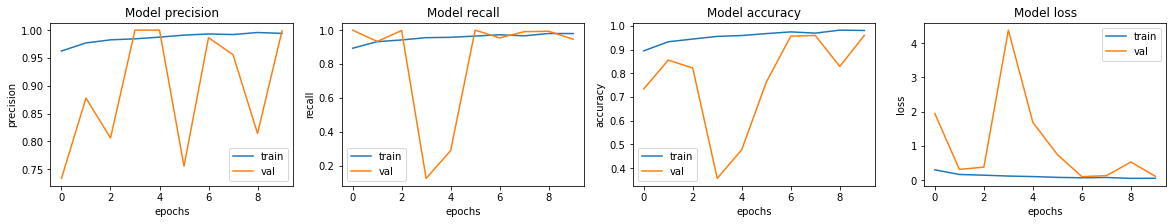

In [46]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [47]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 108ms/step - loss: 1.0192 - accuracy: 0.7788 - precision: 0.7490 - recall: 0.9718
Loss: 1.019160509109497,
Accuracy: 0.7788461446762085,
Precision: 0.7490118741989136,
Recall: 0.971794843673706


# augmentation 전

## 이미지 
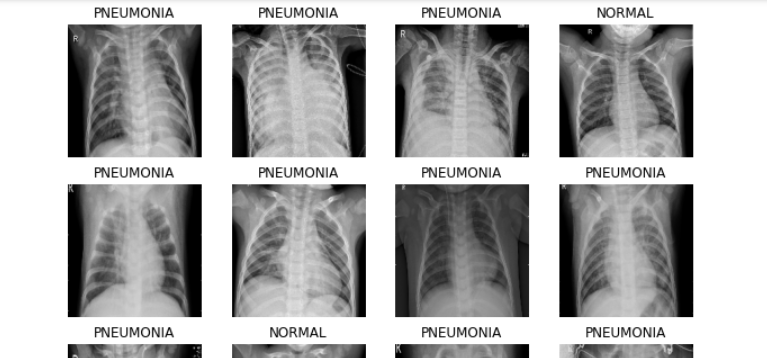
## CNN
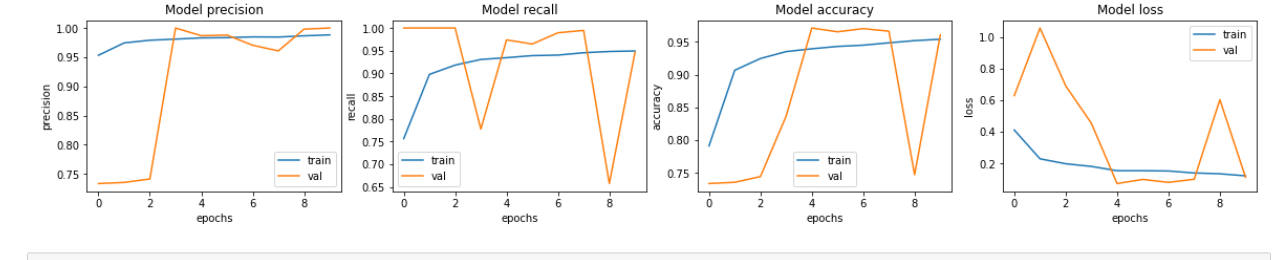   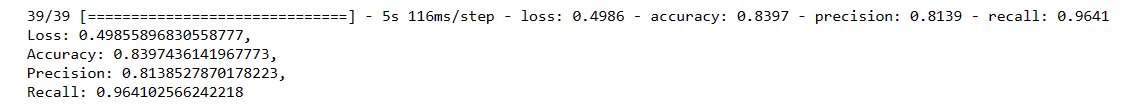
## ResNet-18
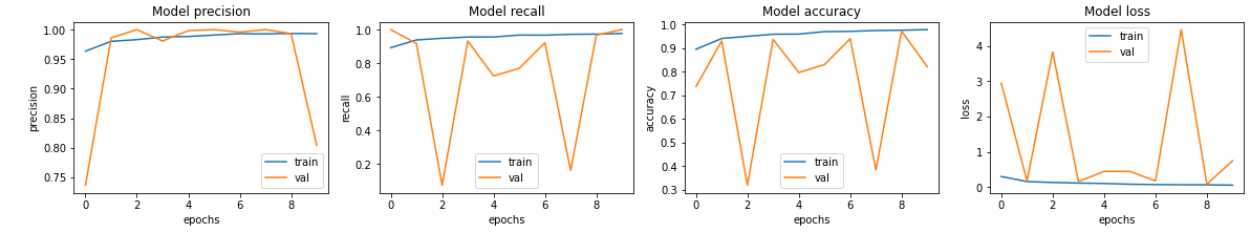

# augmentation 후

## 이미지
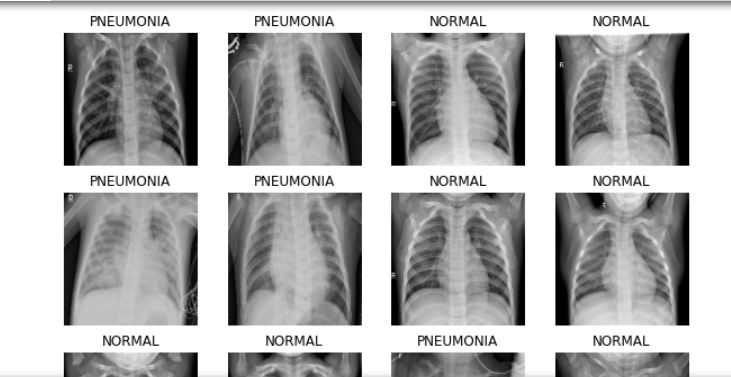  

## CNN
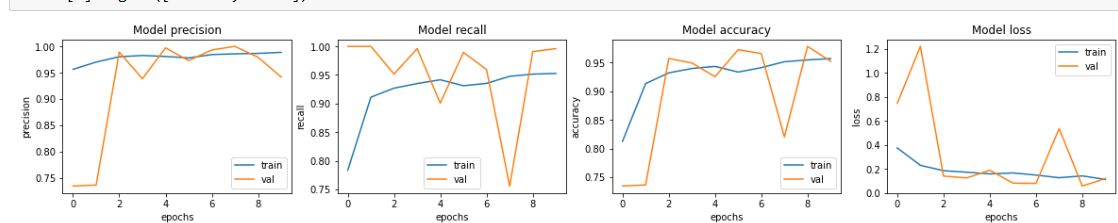  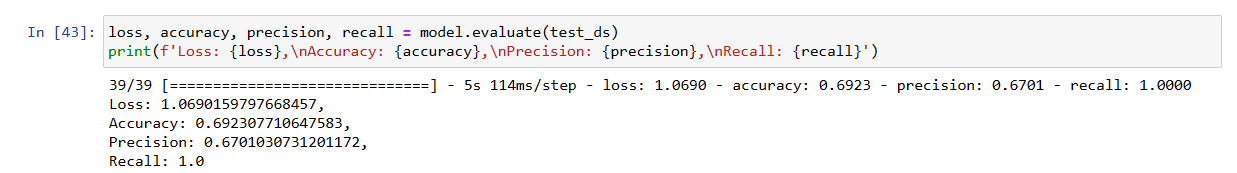
## ResNet-18
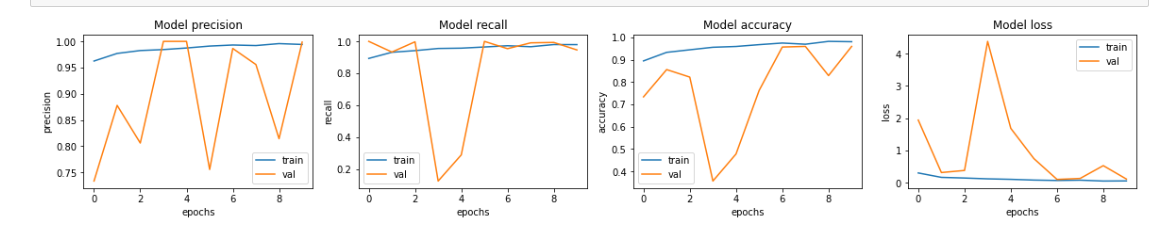 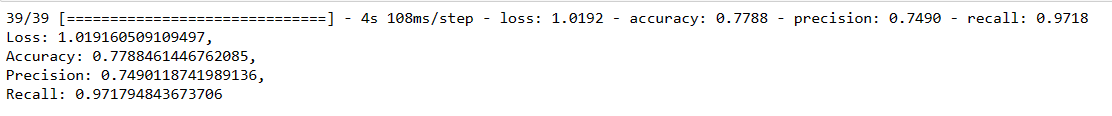

# reference 
https://hnsuk.tistory.com/31  

https://github.com/dalgu90/resnet-18-tensorflow  

https://www.bing.com/search?q=Augmentation+tensorflow&qs=n&form=QBRE&sp=-1&ghc=1&lq=0&pq=augmentation+tensorflo&sc=6-22&sk=&cvid=4705424972AF47C2AB5B3D9DA6058F3A&ghsh=0&ghacc=0&ghpl=


# 회고
오늘은 의료용 X-ray 데이터 가지고 cnn과 Resnet-18로 성능을 평가하였다. 평소 의료데이터에 관심이 있었던 나여서 프로젝트가 재미있게 다가왔고 resnet-18은 처음 사용해보는거 같은데 이론에 대해선 아직 이해하지 못했다. 18개의 레이어를 사용하는 개념으로만 넘어갔다... 레퍼런스를 보며 코드 사용을 어떻게 해야하는지 정도로만 이해했다. 또한 이미지 argument를 할 때 기존 데이터에 더해지는줄 알고 데이터 사이즈를 계속 해서 보았는데 그대로여서 확인해본 결과 기존 데이터에서 랜덤으로 바뀌게 되는거였는데 이렇게 되면 데이터셋은 크기가 변화하지 않는데 차이가 있을지도 아직 의문스럽다..사실 이 프로젝트를 하면서도 이게 모델이 성능이 좋아지는건지 아닌지 제대로 느끼지 못하지만 계속해서 공부해 나가다보면 답을 찾을 수 있지 않을까 싶다.  